03_ResNet18_TransferLearning.ipynb

# Transfer Learning with Resnet18 in Pytorch

In this notebook I will perform Transfer Learning with ResNet18 using images of size 128 x 128, from the [DeepFire dataset](https://doi.org/10.1155/2022/5358359).

# Import Libraries

In [7]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import time

In [8]:
# installed new module to show model summary
from torchinfo import summary

## Import Custom Modules

In [2]:
import sys 
sys.path

['/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python312.zip',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/site-packages']

In [3]:
sys.path.append('..')

In [5]:
sys.path

['/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python312.zip',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/site-packages',
 '..']

# Define Hyperparameters

Here we're using the same hyperparameters as the publication.

In [10]:
BATCH_SIZE = 64
LEARNING_RATE = 0.01
N_EPOCHS = 50
N_CLASSES = 2

# to be used for height and width of final image
IMAGE_SIZE = 128

In [11]:
# Set manual seed for repeatability
RANDOM_SEED = 42
gen = torch.manual_seed(RANDOM_SEED)

# Prepare Data

## Define Custom Class and Paths

In [12]:
# Import Custom Dataset Class
from src.data.create_dataset import CustomFireImagesDataset

Define paths to dataset and annotations file

In [13]:
path_to_dataset = '../data_preprocessing/02_forest_fire_dataset/'
annotations_file_test = 'labels_02_test_dataset_prep.csv'
annotations_file_train = 'labels_02_train_dataset_prep.csv'

In [14]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import v2

## Load Dataset and obtain Statistics

First define the transformations to get statistics

In [15]:
# Convert uint8 to float and divide by 255. 
# This is the equivalent of ToTensor() when used on a PIL image

curr_transf = transforms.Compose([transforms.v2.ToDtype(torch.float),
                                  transforms.Normalize([0,0,0],[255,255,255]),
                                  transforms.Resize(size=(IMAGE_SIZE,IMAGE_SIZE))
                                 ])

The `non_test_dataset` will be split into training and validation

In [16]:
non_test_dataset = CustomFireImagesDataset(annotations_file_train,path_to_dataset,
                                           transform = curr_transf
                                          )

In [17]:
len(non_test_dataset)

1520

In [18]:
# split into validation and train set
val_set, train_set = random_split(non_test_dataset,[0.2,0.8],
                                  generator = gen)

Calculate statistical properties

In [19]:
from src.data.dataset_properties import dataset_stat_prop

In [20]:
mean_train,std_train = dataset_stat_prop(train_set)

In [21]:
print('Statistics of Train Dataset')
print('Mean\t',mean_train)
print('STD\t',std_train)

Statistics of Train Dataset
Mean	 tensor([0.4249, 0.3509, 0.2731])
STD	 tensor([0.2766, 0.2402, 0.2612])


We'll use these values later on to normalize the inputs for training

## Define Train, Validation, and Test Data

In [22]:
# similar to before, but added an additional normalization
# according to the statistics we calculated

curr_transf = transforms.Compose([transforms.v2.ToDtype(torch.float),
                                  transforms.Normalize([0,0,0],[255,255,255]),
                                  transforms.Resize(size=(IMAGE_SIZE,IMAGE_SIZE)),
                                  transforms.Normalize(mean_train,std_train)
                                 ])

In [23]:
# Define image classes
img_classes = ('non-fire','fire')

In [24]:
# First, create Datasets for non-testing and Testing
non_test_dataset =  CustomFireImagesDataset(annotations_file_train, path_to_dataset,
                                         transform = curr_transf
                                        )


test_dataset = CustomFireImagesDataset(annotations_file_test, path_to_dataset,
                                       transform = curr_transf
                                      )


In [25]:
# split into validation and train datasets
val_dataset, train_dataset = random_split(non_test_dataset,[0.2,0.8],
                                  generator = gen)

Just a quick check

In [26]:
print('Train Dataset\t',len(train_dataset))
print('Validation Dataset\t',len(val_dataset))
print('Test Dataset\t',len(test_dataset))

Train Dataset	 1216
Validation Dataset	 304
Test Dataset	 380


In [27]:
# Next, create the DataLoaders
# Note that we're only shuffling the train dataloader

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE,
                              shuffle = True, num_workers = 2)

val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE,
                            shuffle = False, num_workers = 2)

test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE,
                             shuffle = False, num_workers = 2)

## Plot Images from Sample Batch

In [25]:
from src.visualization.plot_images import display_image_batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 fire  fire non-fire  fire  fire  fire  fire  fire non-fire  fire  fire  fire non-fire  fire non-fire non-fire non-fire non-fire  fire  fire non-fire  fire  fire non-fire  fire  fire  fire  fire non-fire non-fire  fire  fire  fire  fire  fire  fire  fire  fire non-fire non-fire  fire  fire non-fire  fire  fire non-fire non-fire non-fire non-fire non-fire  fire non-fire  fire  fire  fire  fire  fire  fire non-fire  fire  fire  fire non-fire  fire


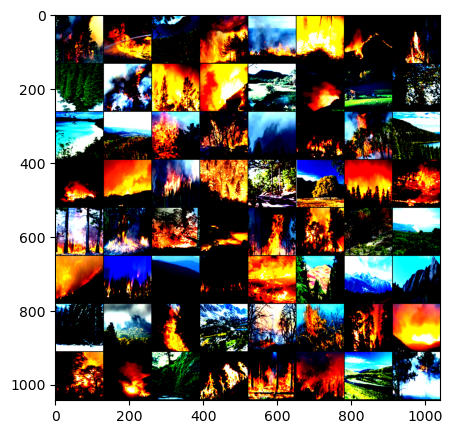

In [26]:
display_image_batch(train_dataloader,1,img_classes)

Note in a future implementation we need to adjust the figure size, as well as the labelling.

# Prepare Model (Resnet18)
Here we're downloading Resnet18 with the default weights used for the ImageNet classification task. We'll modify the last layer to perform transfer learning.

## Download Model

In [27]:
resnet18 = models.resnet18(weights = 'DEFAULT')

In [28]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We can see that the last layer has 512 inputs and 1000 outputs. This last number corresponds to the 1000 classes that the ImageNet problem originally required.

## Freeze Model Parameters

First freeze the model parameters, to avoid training them.

In [29]:
for param in resnet18.parameters():
    param.requires_grad = False

## Modify Final Layers

Next we modfify the last layer to do transfer learning:
- The number of inputs is still 512
- The number of outputs now equals the number of classes (2)

In [30]:
resnet18.fc

Linear(in_features=512, out_features=1000, bias=True)

In [31]:
resnet18.fc = nn.Linear(in_features = 512, out_features = N_CLASSES, bias = True)

In [32]:
#check all changes were effected
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Important Note
Please note that we're choosing to have the model output the predicted logits (as opposed to having the hard or soft probabilities)

## Model Summary

In [33]:
summary(resnet18,(BATCH_SIZE,3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 2]                   --
├─Conv2d: 1-1                            [64, 64, 64, 64]          (9,408)
├─BatchNorm2d: 1-2                       [64, 64, 64, 64]          (128)
├─ReLU: 1-3                              [64, 64, 64, 64]          --
├─MaxPool2d: 1-4                         [64, 64, 32, 32]          --
├─Sequential: 1-5                        [64, 64, 32, 32]          --
│    └─BasicBlock: 2-1                   [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                  [64, 64, 32, 32]          (36,864)
│    │    └─BatchNorm2d: 3-2             [64, 64, 32, 32]          (128)
│    │    └─ReLU: 3-3                    [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                  [64, 64, 32, 32]          (36,864)
│    │    └─BatchNorm2d: 3-5             [64, 64, 32, 32]          (128)
│    │    └─ReLU: 3-6                    [64, 64, 32, 32]  

# Define Optimizer and Loss Function

We'll use Adam optimizer. Note we're changing the learning rate to 0.001 to match that used during the training of VGG.

In [34]:
optimizer = torch.optim.Adam(resnet18.parameters(), lr = 0.001)

For loss function we'll use the Cross Entropy loss

In [35]:
loss_function = nn.CrossEntropyLoss()

# Define Training and Validation Loop

Here we're defining the function that's going to abstract the training and validation loops, for a given set of parameters
- model
- loss function
- optimizer
- number of epochs
- train and validation dataloaders

The outputs include
- the model after training
- a dictionary with the losses and accuracies for training and validation

In [36]:
from src.models.train_models import train_and_validate

In [37]:
help(train_and_validate)

Help on function train_and_validate in module src.models.train_models:

train_and_validate(model, loss_function, optimizer, N_EPOCHS, train_dataloader, val_dataloader)
    Function to run training and validation loops for a given model

    Parameters
    ----------
    model : class
        Model to be trained
    loss_function : class
        Instance of a loss function
    optimizer : class
        Instance of optimizer to be used
    N_EPOCHS : integer
        Number of epochs to be used for training
    train_dataloader : dataloader
        Training set dataloader
    val_dataloader : dataloader
        Validation set dataloader

    Returns
    -------
    tuple
        model after training
        history dictionary containing
            train loss
            train accuracy
            validation loss
            validation accuracy



# Helper function for Losses and Accuracy

In [38]:
from src.visualization.plot_model_eval import plot_loss_acc

# Train the Model

We now get to the training phase. We have defined already a number of hyperparameters, but we'll try with a shorter number of epochs.

In [38]:
resnet18_trained, history = train_and_validate(resnet18,loss_function,optimizer,
                                    20,train_dataloader,val_dataloader)

19:18:27	Epoch: 1/20	Train loss: 0.6236	Val. loss: 0.3647	Train acc.: 70.31	Val. acc.: 89.58
19:19:07	Epoch: 2/20	Train loss: 0.2745	Val. loss: 0.2033	Train acc.: 93.59	Val. acc.: 96.15
19:19:47	Epoch: 3/20	Train loss: 0.1841	Val. loss: 0.1489	Train acc.: 95.72	Val. acc.: 96.77
19:20:25	Epoch: 4/20	Train loss: 0.1458	Val. loss: 0.1298	Train acc.: 96.22	Val. acc.: 97.08
19:21:05	Epoch: 5/20	Train loss: 0.1224	Val. loss: 0.1140	Train acc.: 97.37	Val. acc.: 97.81
19:21:43	Epoch: 6/20	Train loss: 0.1164	Val. loss: 0.1117	Train acc.: 96.79	Val. acc.: 97.50
19:22:21	Epoch: 7/20	Train loss: 0.0993	Val. loss: 0.0984	Train acc.: 97.70	Val. acc.: 98.12
19:22:58	Epoch: 8/20	Train loss: 0.0949	Val. loss: 0.0985	Train acc.: 97.78	Val. acc.: 97.19
19:23:38	Epoch: 9/20	Train loss: 0.0871	Val. loss: 0.0891	Train acc.: 97.53	Val. acc.: 97.81
19:24:17	Epoch: 10/20	Train loss: 0.0858	Val. loss: 0.0884	Train acc.: 97.78	Val. acc.: 97.50
19:24:55	Epoch: 11/20	Train loss: 0.0819	Val. loss: 0.0865	Train acc.

## Plot Model Losses and Accuracy

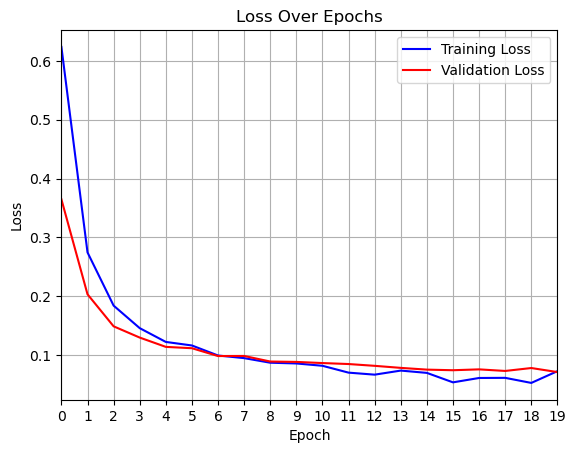

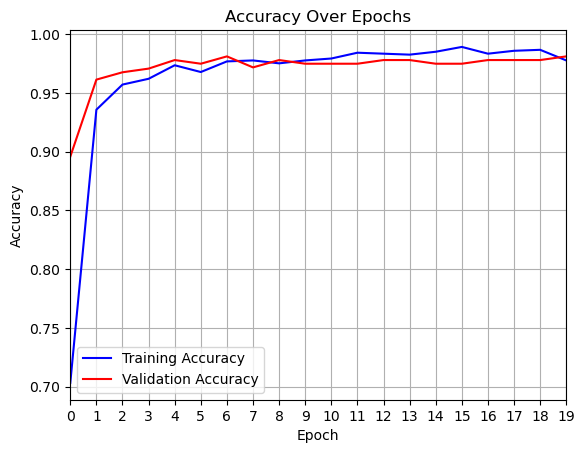

In [39]:
plot_loss_acc(history)

From the graphs, we can see that the training and validation losses are very close to one another, meaning that the model is generalizing well from train to test data. Also note that it only took about 15 min to train for 20 epochs. We'll leave the model unchanged for now

## Save Model

In [50]:
# save the state model of the trained model
torch.save(resnet18_trained.state_dict(), "resnet18_v2_trained.pt")

# Evaluate Model

We'll cycle the model over the test data and see how well the model predicts the test images. Since we're not interested in training in random order, we'll just re-instantiate the test dataset and dataloader

In [9]:
# Uncomment in case of reloading model
from src.models.model_transfer_learning import resnet18_transfer_learning
resnet18_trained = resnet18_transfer_learning(2)
resnet18_trained.load_state_dict(torch.load("resnet18_v2_trained.pt"))
resnet18_trained.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
label_list = []
pred_list = []

for batch in test_dataloader:
    # Get images and labels from batch
    images, true_labels = batch
    
    pred_logits = resnet18_trained(images)

    # Get predicted labels (hard predictions) on images
    # currently the implementation doesn't account for this
    pred_labels = torch.argmax(pred_logits, dim = 1)

    label_list.extend(list(true_labels.numpy()))
    pred_list.extend(list(pred_labels.numpy()))

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

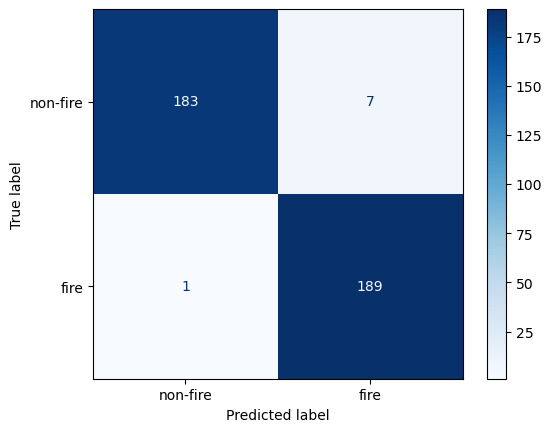

In [32]:
# calculate the confusion matrix 
cm = confusion_matrix(label_list, pred_list)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = img_classes)

fig, ax = plt.subplots()
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap = 'Blues')
plt.xticks(rotation = 0)
plt.show()

In [33]:
report = classification_report(label_list,pred_list,digits = 4)
print(report)

              precision    recall  f1-score   support

           0     0.9946    0.9632    0.9786       190
           1     0.9643    0.9947    0.9793       190

    accuracy                         0.9789       380
   macro avg     0.9794    0.9789    0.9789       380
weighted avg     0.9794    0.9789    0.9789       380



We see that the F1-score of the model is 0.9793 for class 1

Also note there are only 1 false negatives and 3 false positives. This explains why the model had both training and validation losses so similar. 

We'll take a closer look at the instances where there were misclassifications in the next section.

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

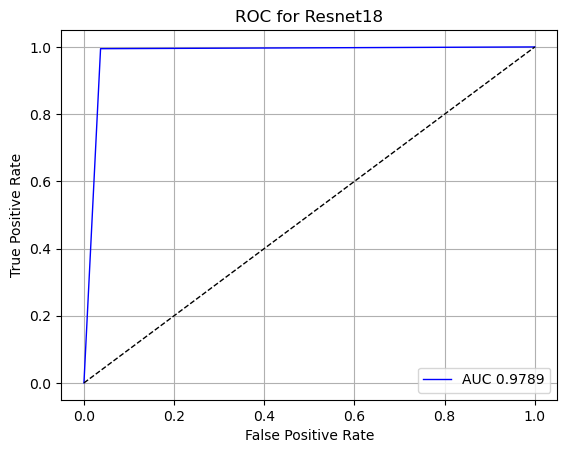

In [35]:
fpr, tpr, _ = roc_curve(label_list,pred_list)
score = roc_auc_score(label_list,pred_list)

plt.figure()
plt.plot(fpr,tpr, color = 'b', lw = 1, label = f'AUC {score:0.4f}')
plt.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()
plt.title('ROC for Resnet18')
plt.legend()
plt.show()

The AUC score of 0.9789 is very close that reported on the reference [publication](https://doi.org/10.1155/2022/5358359), of 0.9889 and it indicates our trained model is doing a very good classification task.

# Conclusion

We've successfuly trained Resnet18 using transfer learning and images of 128 x 128 pixels. 
The AUC score is very close to that from the reference publication.

In a separate notebook, we'll further analyze the nature of the False Positives and False Negatives and compare with ResNet models.

Additionally, we will further abstract some of the model evaluation calculations, to avoid having too much code cluttering the notebook.